## Make a normalized embedded object of the HLCA core + Thienpont_2018 data after mapping with scArches and cluster

Here we combine the HLCA core with the Thienpont_2018 lung cancer dataset, and generate a umap (based on the integrated embedding from scArches), clustering, and normalized counts.

### Import modules, set paths:

Modules:

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append(f"../../scripts")
import nested_clustering

For pretty code formatting (not needed to run code):

In [2]:
%load_ext lab_black

Paths:

In [3]:
path_atlas_extension_embedding = "../../data/HLCA_extended/HLCA_extended/HLCA_extended_scarches_emb.h5ad"  # for up-to-date metadata thienpont
path_HLCA_core = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
path_thienpont_counts = (
    "../../data/HLCA_extended/extension_datasets/ready/full/lambrechts.h5ad"
)
path_label_transfer = (
    "../../results/HLCA_ext_label_transfer/transfered_labels_query_only.csv"
)
path_output_core_thienpont_adata = "../../data/HLCA_extended/HLCA_core_plus_single_study/HLCA_thienpont_2018_adata_full_tcnorm_log1p.h5ad"

Load files:

In [4]:
adata_core = sc.read_h5ad(path_HLCA_core)
adata_thienpont = sc.read_h5ad(path_thienpont_counts)
adata_ext_emb = sc.read_h5ad(path_atlas_extension_embedding)
label_tr_res = pd.read_csv(path_label_transfer, index_col=0)

Set figure parameters:

In [5]:
sc.set_figure_params(dpi=100, figsize=(4, 4))

### Combine core, thienpont_2021, and latent embedding:

Make indices match: add a suffix to the raw data indices

In [6]:
new_index = [f"{idx}_lambrechts" for idx in adata_thienpont.obs.index]

In [7]:
if not adata_thienpont.obs.index[0].endswith("_lambrechts"):
    adata_thienpont.obs.index = new_index

check if all indices match now:

In [8]:
adata_thienpont.obs.index.isin(adata_ext_emb.obs.index).sum() == adata_thienpont.n_obs

True

add embedding to thienpont raw:

In [9]:
adata_thienpont.obsm["X_scanvi_emb"] = adata_ext_emb[adata_thienpont.obs.index, :].X

copy .obs from embedding object:

In [10]:
for obs_col in adata_ext_emb.obs.columns:
    if obs_col not in adata_thienpont.obs.columns:
        adata_thienpont.obs[obs_col] = adata_ext_emb.obs.loc[
            adata_thienpont.obs.index, obs_col
        ]

remove unused categories from categoricals:

In [11]:
for col in adata_thienpont.obs.columns:
    if adata_thienpont.obs[col].dtype.name == "category":
        adata_thienpont.obs[col] = adata_thienpont.obs[
            col
        ].cat.remove_unused_categories()

check if counts are raw:

In [12]:
adata_thienpont.X[:10, :20].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

Set the adata core to its raw counts (we will use a simple total counts normalization for both the core and the thienpont data for the downstream gene-based analysis to be consistent, SCRAN is too memory-expensive for the moment, and we will not be using the normalized counts extensively). Note that the integration/mapping is based on raw counts and will not be affected.

check the median total counts of adata.core, and normalize thienpont data to that same total count value:

In [13]:
adata_core.X = adata_core.layers["counts"]

In [14]:
adata_core.X[:10, :10].toarray()

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  2.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  1.,  0.,  0.,  0.,  2.,  1., 29.,  1.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

normalize to median total counts and log-transform:

In [16]:
median_tc = np.array(np.median(adata_core.X.sum(axis=1), axis=0))[0][0]

In [17]:
print("Median total counts HLCA:", median_tc)

Median total counts HLCA: 4461.0


In [18]:
sc.pp.normalize_per_cell(adata_core, counts_per_cell_after=median_tc)

delete scran size factors to prevent confusion:

In [19]:
del adata_core.obs["size_factors"]

log-transform:

In [20]:
sc.pp.log1p(adata_core)

normalize thienpont data with same simple total counts normalization, and log-transform:

In [21]:
adata_thienpont.layers["counts"] = adata_thienpont.X

In [22]:
sc.pp.normalize_per_cell(adata_thienpont, counts_per_cell_after=median_tc)

In [23]:
sc.pp.log1p(adata_thienpont)

remove superfluous parts of adatas:

In [24]:
adata_thienpont.var.drop(columns=adata_thienpont.var.columns, inplace=True)

In [25]:
cols_core_to_remove = [
    col for col in adata_core.obs.columns if col.startswith("entropy")
] + ["ann_new", "original_ann_new"]

In [26]:
adata_core.obs.drop(columns=cols_core_to_remove, inplace=True)

In [27]:
del adata_core.layers["counts"]
del adata_core.obsp
del adata_core.varm
del adata_core.uns

In [28]:
obsm_cats_to_remove_core = list()
for obsm_cat in adata_core.obsm.keys():
    if obsm_cat != "X_scanvi_emb":
        obsm_cats_to_remove_core.append(obsm_cat)
for obsm_cat in obsm_cats_to_remove_core:
    del adata_core.obsm[obsm_cat]

In [29]:
var_cols_to_drop_core = [
    col
    for col in adata_core.var.columns
    if col not in ["gene_symbols", "highly_variable"]
]
adata_core.var.drop(columns=var_cols_to_drop_core, inplace=True)

In [30]:
del adata_thienpont.layers["counts"]
del adata_thienpont.uns

concatenate adatas:

In [31]:
adata_core_thienpont = sc.concat(
    adatas=(adata_core, adata_thienpont), join="outer", index_unique=None
)

the concatenation causes some errors with storing when nans are combined with categoricals, we'll fix that as follows:

In [90]:
for obscol in adata_core_thienpont.obs.columns:
    if type(adata_core_thienpont.obs[obscol].values) == "category":
        adata_core_thienpont.obs[obscol] = adata_core_thienpont.obs[obscol].astype(str)
    elif (
        pd.api.types.is_numeric_dtype(adata_core_thienpont.obs[obscol].values) == False
    ):
        adata_core_thienpont.obs[obscol] = adata_core_thienpont.obs[obscol].astype(str)
for varcol in adata_core_thienpont.var.columns:
    if type(adata_core_thienpont.var[varcol].values) == "category":
        adata_core_thienpont.var[varcol] = adata_core_thienpont.var[varcol].astype(str)
    elif (
        pd.api.types.is_numeric_dtype(adata_core_thienpont.var[varcol].values) == False
    ):
        adata_core_thienpont.var[varcol] = adata_core_thienpont.var[varcol].astype(str)
adata_core_thienpont.X = np.nan_to_num(adata_core_thienpont.X)

shuffle cell order (for plotting) and set nans in .X to 0:

In [34]:
# adata_core_thienpont.X = np.nan_to_num(adata_core_thienpont.X)
# index_list = adata_core_thienpont.obs.index.tolist()
# np.random.shuffle(index_list)
# adata_core_thienpont = adata_core_thienpont[index_list, :]

add nested clustering:

In [93]:
n_levels = 4

clustering level: 1 ...


/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


clustering level: 2 ...
Not re-doing pca before nested clustering iterations!
Cluster: 0
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 1
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 2
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 3
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering


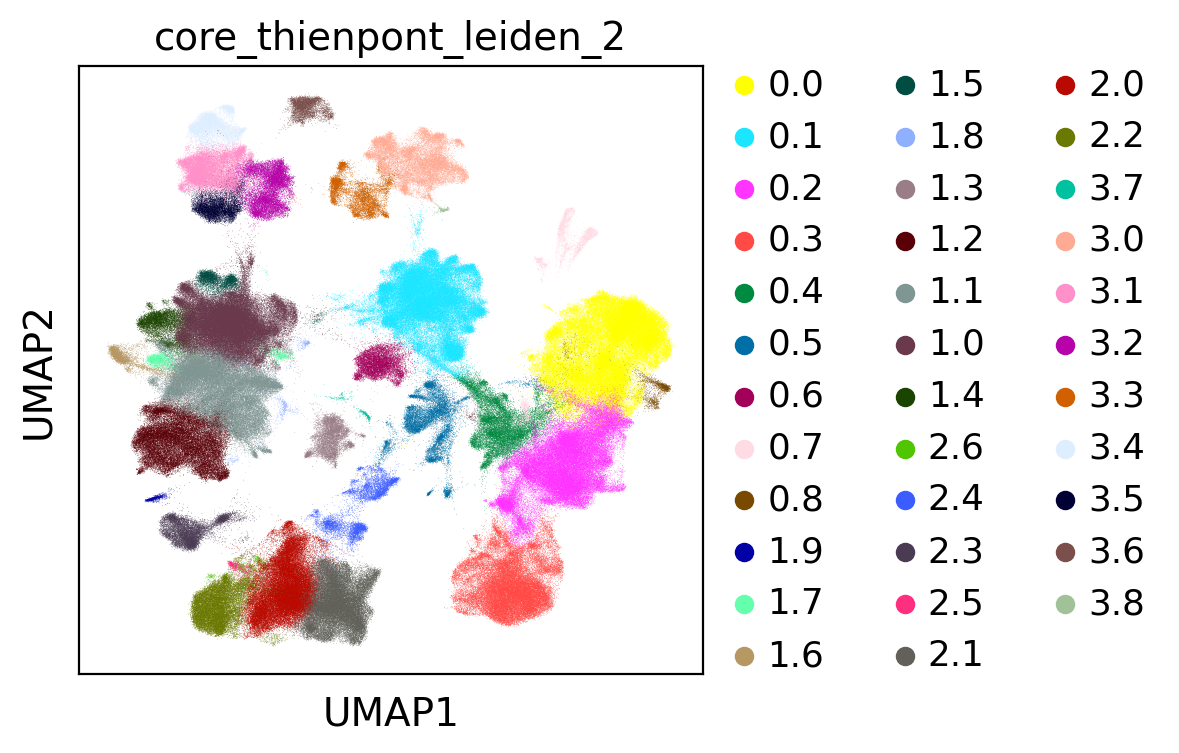

clustering level: 3 ...
Not re-doing pca before nested clustering iterations!
Cluster: 0.0
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.1
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.2
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.3
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.4
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.5
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.6
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.7
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.8
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 1.0
reclustering...

calculatin

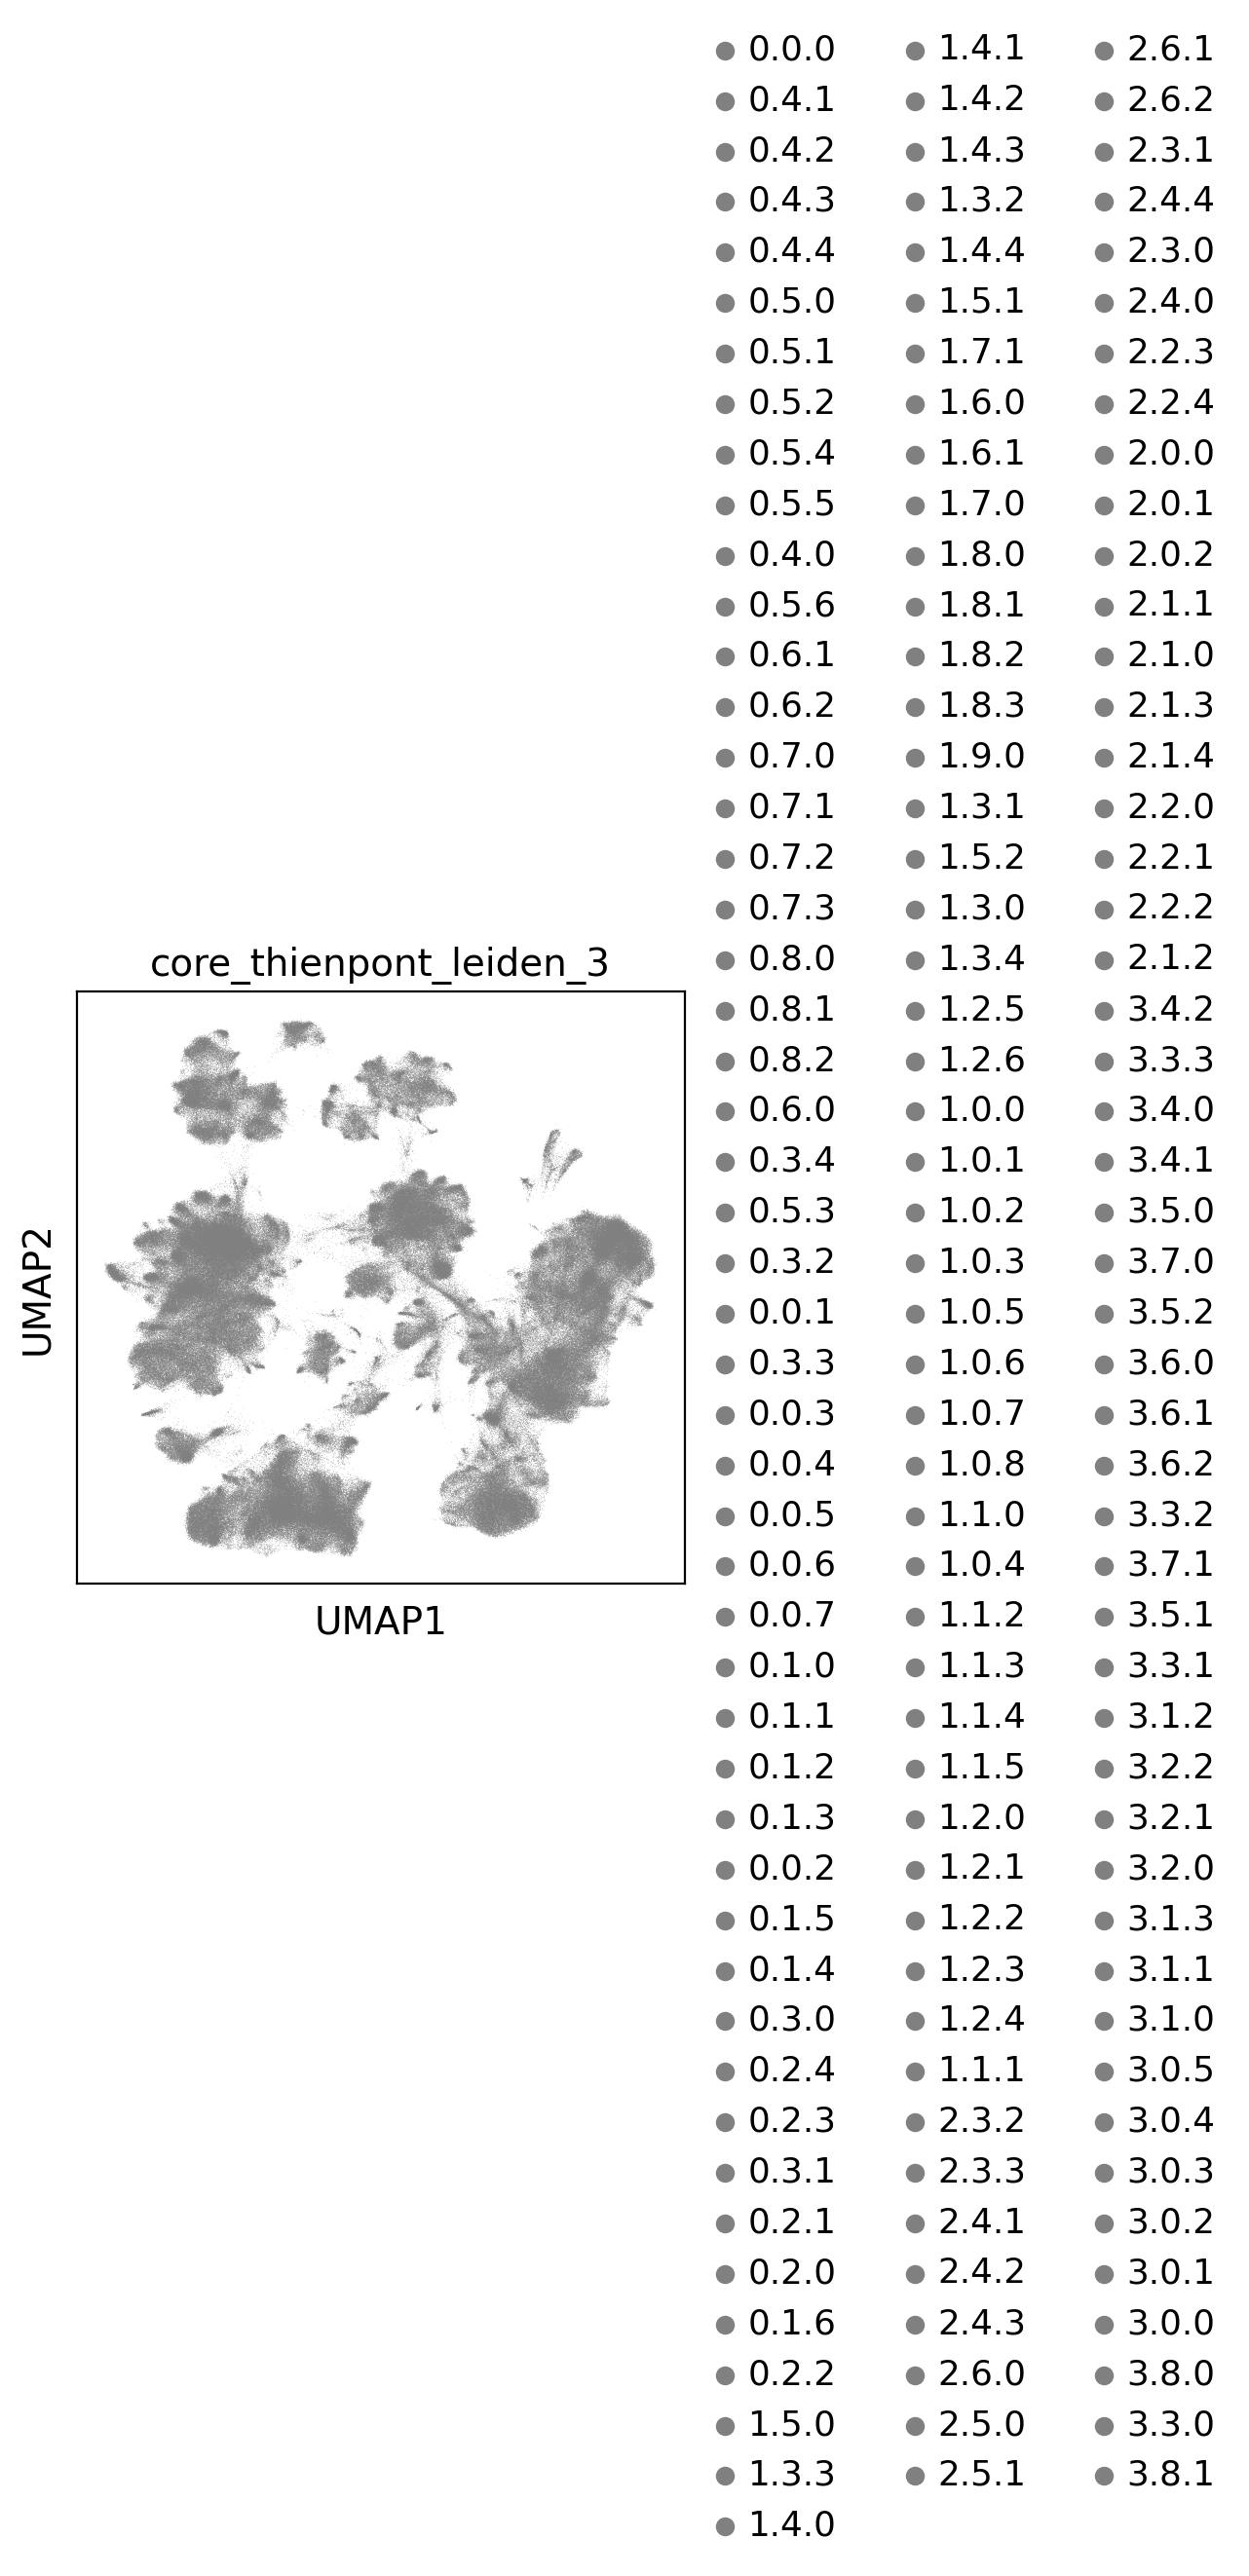

clustering level: 4 ...
Not re-doing pca before nested clustering iterations!
Cluster: 0.0.0
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.0.1
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.0.2
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.0.3
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.0.4
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.0.5
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.0.6
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.0.7
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.1.0
reclustering...

calculating 30 nearest neighbors
using rep: X_scanvi_emb
clustering
Cluster: 0.1.1
reclust

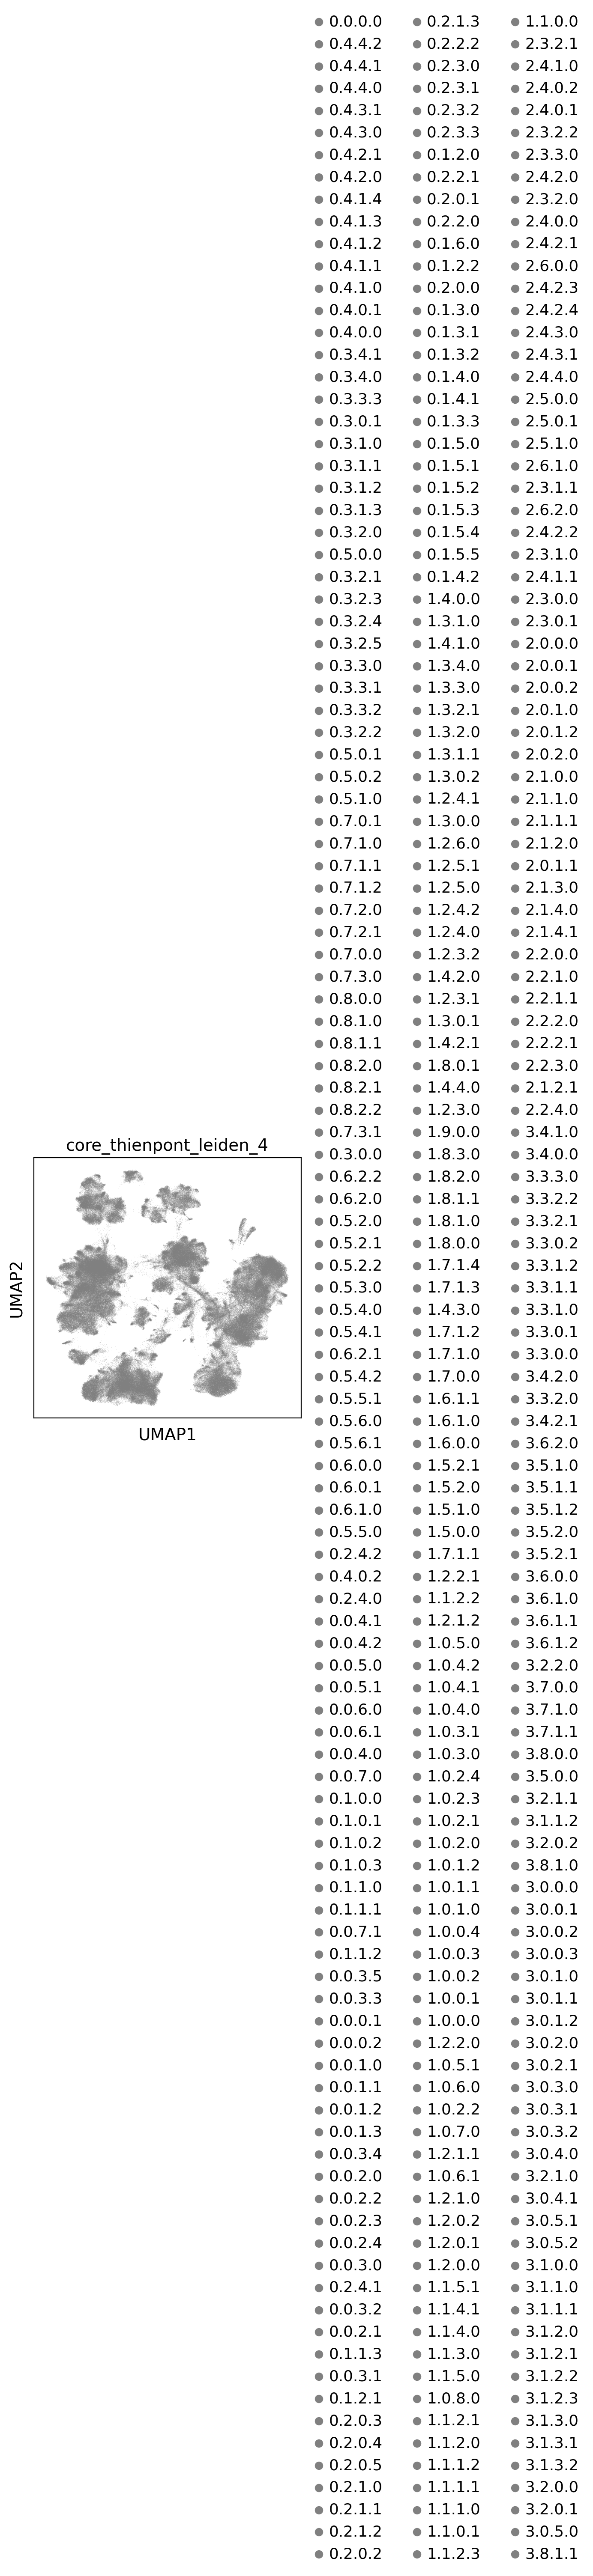

In [94]:
for clustering_level in range(1, n_levels + 1):
    print("clustering level:", clustering_level, "...")
    if clustering_level == 1:
        # skip for re-run
        cluster_name = f"core_thienpont_leiden_1"
        #         first clustering is not nested, so use normal function. Make sure your neighbors are based on embedding.
        sc.pp.neighbors(adata_core_thienpont, use_rep="X_scanvi_emb", n_neighbors=30)
        sc.tl.leiden(adata_core_thienpont, resolution=0.01, key_added=cluster_name)
        sc.tl.umap(adata_core_thienpont)
    else:
        previous_clustering = f"core_thienpont_leiden_" + str(clustering_level - 1)
        cluster_name = f"core_thienpont_leiden_" + str(clustering_level)
        #         perform nested clustering
        #         set parameters:
        res = 0.2
        if clustering_level == 2:
            k = 30
            min_cluster_size = 50
        elif clustering_level == 3:
            k = 15
            min_cluster_size = 30
        elif clustering_level == 4:
            k = 10
            min_cluster_size = 10

        adata_core_thienpont = nested_clustering.add_nested_clustering_blind(
            adata_core_thienpont,
            previous_clustering,
            cluster_name,
            use_rep="X_scanvi_emb",
            cluster_alg="leiden",
            cluster_k=k,
            cluster_res=res,
            min_cluster_size=min_cluster_size,
            redo_pca=False,  # SET THIS TO FALSE FOR SCANVI!!! OR OTHER EMBEDDING-OUTPUT METHODS!!!!!
        )
        # plot
        sc.pl.umap(adata_core_thienpont, color=cluster_name)

Check if all cells from the thienpont data are present (with same barcode) in label transfer results:

In [ ]:
thienpont_cells = adata_core_thienpont.obs.loc[adata_core_thienpont.obs.study == "Thienpont_2018", :].index.tolist()
label_tr_res.index.isin(adata_core_thienpont.obs.index).sum() == len(thienpont_cells)

now add columns:

In [ ]:
for col in label_tr_res.columns:
    adata_core_thienpont.obs[col] = np.nan
    adata_core_thienpont.obs.loc[thienpont_cells, col] = label_tr_res.loc[thienpont_cells, col]

and store:

In [42]:
adata_core_thienpont.write(path_output_core_thienpont_adata)